In [1]:
!pip install tensorflow pandas numpy scikit-learn tensorboard matplotlib streamlit scikeras

In [ ]:
#Data Collection
# we got the dataset already i.e hamlet.txt




In [2]:
# DATA ppo

import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

#load the dataset

with open('hamlet.txt', 'r', encoding='utf-8') as file:
    text = file.read().lower()

tokenizer = Tokenizer()
tokenizer.fit_on_texts([text]) # applies the tokenization on the txt
len(tokenizer.word_index) +1

4818

In [5]:
ip_seq=[]

for line in text.split('\n'):
  token_list = tokenizer.texts_to_sequences([line])[0]
  for i in range(1, len(token_list)):
    n_gram_seq = token_list[:i+1]
    ip_seq.append(n_gram_seq)

#pad Seq
max_seq=max(len(x) for x in ip_seq)
ip_seq=np.array(pad_sequences(ip_seq, maxlen=max_seq, padding='pre'))

ip_seq

array([[   0,    0,    0, ...,    0,    1,  687],
       [   0,    0,    0, ...,    1,  687,    4],
       [   0,    0,    0, ...,  687,    4,   45],
       ...,
       [   0,    0,    0, ...,    4,   45, 1047],
       [   0,    0,    0, ...,   45, 1047,    4],
       [   0,    0,    0, ..., 1047,    4,  193]], dtype=int32)

In [7]:
import tensorflow as tf

x,y=ip_seq[:,:-1],ip_seq[:,-1]
y=tf.keras.utils.to_categorical(y, num_classes=len(tokenizer.word_index)+1)

x_train, x_test, y_train, y=train_test_split(x,y, test_size=0.2, random_state=42)

In [14]:
# Train lstm rnn

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM,Dropout,Embedding,GRU

total_words=len(tokenizer.word_index)+1

model=Sequential()
model.add(Embedding(input_dim=total_words, output_dim=100, input_length=max_seq-1))
model.add(LSTM(150 , return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(100))
model.add(Dense(total_words, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

# to use gru rnn we can just replace the LSTM -> GRU


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 13, 100)           481800    
                                                                 
 lstm_6 (LSTM)               (None, 13, 150)           150600    
                                                                 
 dropout_3 (Dropout)         (None, 13, 150)           0         
                                                                 
 lstm_7 (LSTM)               (None, 100)               100400    
                                                                 
 dense_2 (Dense)             (None, 4818)              486618    
                                                                 
Total params: 1219418 (4.65 MB)
Trainable params: 1219418 (4.65 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [13]:
history=model.fit(x_train, y_train, epochs=50, verbose=1,validation_data=(x_test,y))

Epoch 1/50
644/644 [==============================] - 38s 52ms/step - loss: 6.9204 - accuracy: 0.0324 - val_loss: 6.6904 - val_accuracy: 0.0336
Epoch 2/50
644/644 [==============================] - 34s 52ms/step - loss: 6.4841 - accuracy: 0.0368 - val_loss: 6.7751 - val_accuracy: 0.0416
Epoch 3/50
644/644 [==============================] - 33s 51ms/step - loss: 6.3535 - accuracy: 0.0444 - val_loss: 6.8170 - val_accuracy: 0.0486
Epoch 4/50
644/644 [==============================] - 32s 49ms/step - loss: 6.2182 - accuracy: 0.0506 - val_loss: 6.8253 - val_accuracy: 0.0478
Epoch 5/50
644/644 [==============================] - 33s 52ms/step - loss: 6.0784 - accuracy: 0.0540 - val_loss: 6.8714 - val_accuracy: 0.0519
Epoch 6/50
644/644 [==============================] - 33s 52ms/step - loss: 5.9366 - accuracy: 0.0616 - val_loss: 6.8872 - val_accuracy: 0.0612
Epoch 7/50
644/644 [==============================] - 34s 53ms/step - loss: 5.7964 - accuracy: 0.0699 - val_loss: 6.9336 - val_accuracy:

In [15]:
# Function to predict the next word
def predict_next_word(model, tokenizer, text, max_sequence_len):
    token_list = tokenizer.texts_to_sequences([text])[0]
    if len(token_list) >= max_sequence_len:
        token_list = token_list[-(max_sequence_len-1):]  # Ensure the sequence length matches max_sequence_len-1
    token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
    predicted = model.predict(token_list, verbose=0)
    predicted_word_index = np.argmax(predicted, axis=1)
    for word, index in tokenizer.word_index.items():
        if index == predicted_word_index:
            return word
    return None

In [52]:
input_text="What are you doing here Mr"
print(f"Input text:{input_text}")
max_sequence_len=model.input_shape[1]+1
next_word=predict_next_word(model,tokenizer,input_text,max_sequence_len)
print(f"Next Word PRediction:{next_word}")
print()
print(f"{ input_text} {next_word}")

Input text:What are you doing here Mr
Next Word PRediction:murderer

What are you doing here Mr murderer


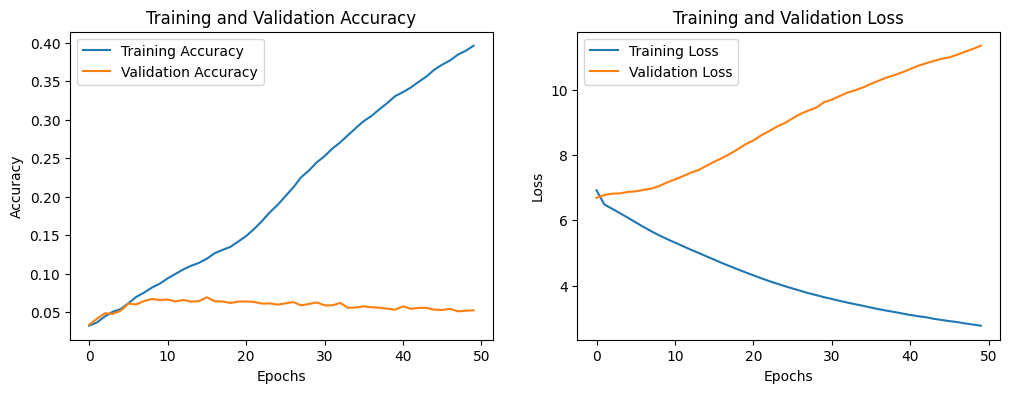

In [53]:
import matplotlib.pyplot as plt

# Plotting the training and validation accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plotting the training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()